# Import Librairies

In [1]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from ast import literal_eval
import pandas as pd
import numpy as np
import re
from collections import Counter
from scipy import sparse as sp_sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from metrics import roc_auc
from itertools import product

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yboge\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load data

In [4]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data
train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')
train.head()
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

# Text preprocessing

In [5]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    text = text.lower()
    text = re.sub(REPLACE_BY_SPACE_RE, ' ', text)
    text = re.sub(BAD_SYMBOLS_RE, '', text)
    text = " ".join([word for word in text.split() if word not in STOPWORDS])
    return text

prepared_questions = []
for line in open('data/text_prepare_tests.tsv', encoding='utf-8'):
    line = text_prepare(line.strip())
    prepared_questions.append(line)
text_prepare_results = '\n'.join(prepared_questions)
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [6]:
# Dictionary of all tags from train corpus with their counts.
tags_counts = {}
# Dictionary of all words from train corpus with their counts.
words_counts = {}
tags_counts = Counter([tag for taglist in y_train for tag in taglist])
words_counts = Counter([word for question in X_train for word in question.split(' ')])

most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]


In [7]:
DICT_SIZE = 5000
WORDS_TO_INDEX = {word[0]:int_idx for int_idx, word in enumerate(sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE])}
INDEX_TO_WORDS = dict(zip(WORDS_TO_INDEX.values(),WORDS_TO_INDEX.keys()))
ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):
    result_vector = np.zeros(dict_size)
    text_tokenized = text.split(' ')
    for token in text_tokenized:
        if token in words_to_index:
            result_vector[words_to_index[token]] += 1
    return result_vector

X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


In [8]:
def tfidf_features(X_train, X_val, X_test):    
    tfidf_vectorizer = TfidfVectorizer(analyzer='word', token_pattern = '(\S+)', min_df = 5, max_df = 0.9, ngram_range=(1,2))
    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_val = tfidf_vectorizer.transform(X_val)
    X_test = tfidf_vectorizer.transform(X_test)   
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

In [9]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

In [10]:
def train_classifier(X_train, y_train):   
    # Create and fit LogisticRegression wraped into OneVsRestClassifier.
    clf = OneVsRestClassifier(LogisticRegression())
    clf.fit(X_train,y_train)
    return clf

In [11]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)


C:\Users\yboge\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yboge\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [12]:
def print_evaluation_scores(y_val, predicted):
    # Accuracy
    print('Acuracy score: {:.2f}'.format(accuracy_score(y_val, predicted)))
    # F1-Score
    print('F1-Score macro-average: {:.2f}'.format(f1_score(y_val,predicted,average='macro')))
    print('F1-Score micro-average: {:.2f}'.format(f1_score(y_val,predicted,average='micro')))
    print('F1-Score weighted-average: {:.2f}'.format(f1_score(y_val,predicted,average='weighted')))
    # Precision
    print('Precision macro-average: {:.2f}'.format(average_precision_score(y_val,predicted,average='macro')))
    print('Precision micro-average: {:.2f}'.format(average_precision_score(y_val,predicted,average='micro')))
    print('Precision weighted-average: {:.2f}'.format(average_precision_score(y_val,predicted,average='weighted')))

In [13]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)


Bag-of-words
Acuracy score: 0.36
F1-Score macro-average: 0.50
F1-Score micro-average: 0.67
F1-Score weighted-average: 0.65
Precision macro-average: 0.34
Precision micro-average: 0.48
Precision weighted-average: 0.51
Tfidf
Acuracy score: 0.33
F1-Score macro-average: 0.45
F1-Score micro-average: 0.64
F1-Score weighted-average: 0.61
Precision macro-average: 0.30
Precision micro-average: 0.46
Precision weighted-average: 0.49


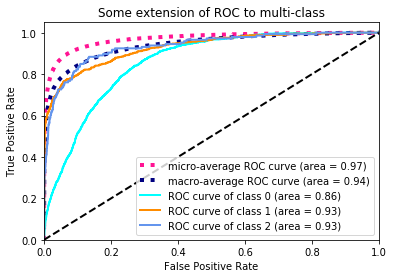

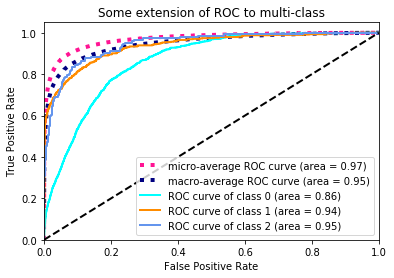

In [16]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)

In [17]:
def grid_search(c,penalty,X_train_mybag,X_train_tfidf,X_val_mybag,X_val_tfidf,y_train,y_val):
    
    # Define model
    clf = OneVsRestClassifier(LogisticRegression(C = c, penalty = penalty))
    
    # Fit and predict mybag
    clf_mybag = clf.fit(X_train_mybag,y_train)
    y_val_predicted_labels_mybag = clf_mybag.predict(X_val_mybag)
 
    # Fit and predict tfidf
    clf_tfidf = clf.fit(X_train_tfidf,y_train)
    y_val_predicted_labels_tfidf = clf_tfidf.predict(X_val_tfidf)
    
    # Evaluate
    print("For parameters C={}, penalty={}".format(c,penalty))
    print("mybag: F1-score = {:.2f}".format(f1_score(y_val, y_val_predicted_labels_mybag, average = 'weighted'
)))
    print("tfidf: F1-score = {:.2f}".format(f1_score(y_val, y_val_predicted_labels_tfidf, average = 'weighted'
)))

C = [0.1,1,10,100]
regularization = ['l1','l2']
grid = list(product(C,regularization))

for c,reg in grid:
    grid_search(c,reg,X_train_mybag,X_train_tfidf,X_val_mybag,X_val_tfidf,y_train,y_val)

C:\Users\yboge\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yboge\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


For parameters C=0.1, penalty=l1
mybag: F1-score = 0.61


C:\Users\yboge\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


tfidf: F1-score = 0.57


C:\Users\yboge\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yboge\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


For parameters C=0.1, penalty=l2


C:\Users\yboge\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


mybag: F1-score = 0.59
tfidf: F1-score = 0.39


C:\Users\yboge\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yboge\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


For parameters C=1, penalty=l1
mybag: F1-score = 0.66
tfidf: F1-score = 0.65


C:\Users\yboge\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yboge\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


For parameters C=1, penalty=l2
mybag: F1-score = 0.65
tfidf: F1-score = 0.61


C:\Users\yboge\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yboge\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


For parameters C=10, penalty=l1
mybag: F1-score = 0.65
tfidf: F1-score = 0.65


C:\Users\yboge\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yboge\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


For parameters C=10, penalty=l2
mybag: F1-score = 0.65
tfidf: F1-score = 0.65


C:\Users\yboge\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yboge\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


For parameters C=100, penalty=l1
mybag: F1-score = 0.62
tfidf: F1-score = 0.59


C:\Users\yboge\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yboge\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


For parameters C=100, penalty=l2
mybag: F1-score = 0.63
tfidf: F1-score = 0.63


In [18]:
clf = OneVsRestClassifier(LogisticRegression(C = 1, penalty = 'l1'))
clf_mybag = clf.fit(X_train_mybag,y_train)
test_predictions = clf_mybag.predict(X_test_mybag)
test_pred_inversed = mlb.inverse_transform(test_predictions)

test_predictions_for_submission = '\n'.join('%i\t%s' % (i, ','.join(row)) for i, row in enumerate(test_pred_inversed))
grader.submit_tag('MultilabelClassification', test_predictions_for_submission)

C:\Users\yboge\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


NameError: name 'grader' is not defined

In [23]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    """
        classifier: trained classifier
        tag: particular tag
        tags_classes: a list of classes names from MultiLabelBinarizer
        index_to_words: index_to_words transformation
        all_words: all words in the dictionary
        
        return nothing, just print top 5 positive and top 5 negative words for current tag
    """
    print('Tag:\t{}'.format(tag))
    
    # Extract an estimator from the classifier for the given tag.
    # Extract feature coefficients from the estimator. 
    coef = classifier.coef_[tags_classes.index(tag)]
    coef_dict = {idx:c for idx,c in enumerate(coef.tolist())}
    sorted_coefs = sorted(coef_dict.items(), key=lambda x: x[1], reverse=True)
    
    # top-5 words sorted by the coefficiens.
    top_positive_words = [index_to_words[i[0]] for i in sorted_coefs[:5]]
    # bottom-5 words  sorted by the coefficients.
    top_negative_words = [index_to_words[i[0]] for i in sorted_coefs[-5:]]

    
    
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [24]:
print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'linux', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)

NameError: name 'classifier_tfidf' is not defined